In [83]:
#MF703 Final Project
#CovarianceMarketNeutralStrategy
#Author: Kevin & Tim 

# Summary:
# Synthetic Index (To be completed...)
# Minimize f(w_1, w_2, ..., w_n) = a * ß_portfolio^2 + var(portfolio)
    # B_portfolio = ∑ wi * ß_i = <ß,wi> = (∑cov(wiRi, R_mkt) / (var(R_mkt)))
    # var(portfolio) = π wi * beta(commodity_i) + ∑ wi * wj * cov(commodity_i, commodity_j) = <w,Cw> = w'Cw
    # a : scalar (to equalize the importance of ß^2 + var(portfolio))
# ßi = cov(synthetic index, commodity_i) / sigma(commodity_i) retrievable via regression
# Goal: find weights (wi) such that a*ß(port)^2 + Var(portfolio) is minimized given constraint: ∑abs(w_i) = 1

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from datetime import datetime

class WeightOptimization:
    
    def __init__(self, syn_index, df_prices, df_strategy):
        self.syn_index = syn_index.fillna(method = 'bfill') # pandas Series indexed by date containing the index returns on that date
        self.df_ret = df_prices.pct_change().dropna() # dataframe containing daily returns. Indexed by date and with columns labeled by commodities
        self.df_strategy = df_strategy # dataframe containing -1,0,1. indexed by date and with columns labeled by commodities
        self.num_securities = len(df_prices.columns)
        self.equal_weighted_days = 0 # counts the number of equal weighted days found in the lifetime of the class
        
    def slicer(self, date, numdays=252):
        """
        date: datetime object
        numdays: lookback length before date
        
        output: the returns of the commodities with non-zero positions on the specified date,
                data going back the specified number of days
        """
        sliced = pd.DataFrame(index = self.df_ret.index)
        date_index = self.df_ret.index.get_loc(date)
        
        # Only considering commodities with non-zero positions
        for column in self.df_strategy.columns:
            if self.df_strategy.loc[date, column] != 0:
                sliced[column] = self.df_ret[column]
        
        # Taking only TTM data of any given commoditiy 
        start_index = max(0, date_index - numdays + 1)
        end_index = date_index + 1
        sliced = sliced.iloc[start_index : end_index]
        
        return sliced
        
    def get_covar(self, date, numdays=252):
        """
        date: datetime object
        numdays: lookback length before date. default is one year
        
        output: DataFrame containing the covariance matrix for commodities with non-zero positions   
        """
        sliced_data = self.slicer(date, numdays)
        cov_matrix = sliced_data.cov()
        
        return cov_matrix
        
    def get_betas(self, date, numdays=252):
        """
        date: datetime object
        numdays: lookback length before date. default is one year
        
        Output: a pandas Series containing the ßs to market of each commodity with non-zero positions
        """
        sliced_data = self.slicer(date, numdays)
        sliced_index = self.syn_index.loc[sliced_data.index] 

        betas = []
        
        X = sliced_index.values.reshape(-1,1)
        
        # regressing each non-zero position commodity on synthetic index to acquire ß
        for column in sliced_data.columns:
            y = sliced_data[column].values.reshape(-1, 1)

            model = LinearRegression()
            model.fit(X,y)
            
            betas.append(model.coef_[0][0])
            
        return pd.Series(betas, index = sliced_data.columns)
        
    def calculate_weights(self, date, alpha=10000):
        """
        date:datetime object
        alpha: the neutrality preference parameter
                (scalar that puts portfolio beta and portfolio variance on the same scale)
        
        output: a numpy array (of length = numcommodities) containing the optimal weights for the specified date and alpha
        """
        #get today's strategy
        strat_today = self.df_strategy.loc[date].values
        
        #remove 0s from strategy
        positions = [v for v in strat_today if v != 0]
        
        #if strategy says don't buy anything, weights are all zero.
        if len(positions) == 0:
            return [0]*self.num_securities
        
        #get covariance and correlation to market of the individual commodities
        C = self.get_covar(date)
        betas = self.get_betas(date)
        
        #define quantity to be minimized
        def objective_function(w):
           term1 = alpha * (w @ np.transpose(betas))**2
           term2 = w @ C @ np.transpose(w)
           return term1 + term2

        # Create a function to generate constraints based on the strategy
        def generate_constraints(strategy):
            constraints = []
            
            # direction constraints: weights must be positive or negative as dictated by strategy
            for i, s in enumerate(strategy):
                if s == 1:
                    constraints.append({'type': 'ineq', 'fun': lambda weights, i=i: weights[i]})
                elif s == -1:
                    constraints.append({'type': 'ineq', 'fun': lambda weights, i=i: -weights[i]})
                    
            # leverage constraint: absolute values of weights add to 1
            constraints.append({'type': 'eq', 'fun': lambda weights: np.abs(weights).sum() - 1})
            
            # none of the weights have absolute value greater than 0.5
            for i in range(len(strategy)):
                constraints.append({'type': 'ineq', 'fun': lambda weights, i=i: 0.5 - np.abs(weights[i])})
            
            return constraints
        
        # Initial guess for the weights
        initial_guess = [1/len(positions) * x for x in positions]
        #initial_guess = [1*positions[2]] + [0]*(len(positions)-1)   
        
        # Generate constraints based on the strategy
        constraints = generate_constraints(positions)
 
        # Perform the optimization
        result = minimize(fun=objective_function,
                          x0=initial_guess,
                          method = 'SLSQP',
                          constraints=constraints,
                          tol = 0.000000001,
                          options = {'maxiter': 100000000}) # increase number to increase accuracy of optimizer
        
        if result.success:
            optimized = result.x # store the optimal weights
        else:
            raise ValueError("Optimization failed.")
        
        #if it's equal weighted, print warning and count
        unchanged = all(abs(x) == abs(optimized[0]) for x in optimized[1:])
        if unchanged:
            print("Warning: optimizer returned equal weights on date:", date)
            self.equal_weighted_days += 1

        #re-insert the zero weights for all the commodities with position 0
        final_weights = np.zeros(self.num_securities)
        ptr = 0
        for i in range(len(strat_today)):
            if strat_today[i] != 0:
                final_weights[i] = optimized[ptr]
                ptr += 1
        
        #return final result as an array with length num_securities
        return final_weights
    
    def print_results(self, date, alpha = 10000):
        """
        date: datetime object
        alpha: the neutrality preference parameter
        output: none
        
        using the optimal weights for the given date and alpha,
        prints out the resulting (portfolio beta)^2 and variance
        """
        #get today's weights, covariance matrix, betas to market, and strategy
        weights = self.calculate_weights(date)
        C = self.get_covar(date)
        betas = self.get_betas(date)
        strat_today = self.df_strategy.loc[date].values
        
        #w vector: the weights for the commodities we are holding
        w = [weights[i] for i in range(self.num_securities) if strat_today[i] != 0] 
        
        #compute the two quantities
        scaled_port_beta = alpha * (w @ np.transpose(betas))**2
        port_variance = w @ C @ np.transpose(w)
        
        print("Date = "+ str(date) + ", alpha = " + str(alpha))
        print("Strategy:", strat_today)
        print("Weights:", weights)
        print("portfolio beta to market (squared) times alpha:", scaled_port_beta)
        print("portfolio variance", port_variance)
        return
 
"""The initial function of the class"""
#     def plot_frontier(self, date):
#         """
#         Given a certain date, plots the maximum neutrality frontier: the optimum correlation to market vs portfolio variance curve as alpha varies from 1 to 200
#         """   
#         C = self.get_covar(date)
#         betas = self.get_betas(date)
#         strat_today = self.df_strategy.loc[date].values
        
#         x_data = []
#         y_data = []
        
#         #iterate through all the alphas
#         for alpha in range(1, 40000, 100):
#             weights = self.calculate_weights(date, alpha)
#             w = [weights[i] for i in range(self.num_securities) if strat_today[i] != 0]
#             beta_squared = (w @ np.transpose(betas))**2
#             port_var = w @ C @ np.transpose(w)
        
#             x_data.append(port_var)
#             y_data.append(beta_squared)
        
#         plt.scatter(x_data,y_data)
        
#         #labels the dots lol
#         #for i, (x, y) in enumerate(zip(x_data, y_data)):
#         #    plt.text(x, y, f'({i})', ha='right', va='bottom')
        
#         #make axes start from 0 if desired
#         plt.xlim(0, max(x_data)*1.1)
#         plt.ylim(0, max(y_data)*1.1)
        
#         plt.xlabel("portfolio variance")
#         plt.ylabel('portfolio beta to market (squared)')
#         plt.title('Switzerland Frontier for ' + str(date))
#         return
   






#     def plot_frontier(self, date):
#         C = self.get_covar(date)
#         betas = self.get_betas(date)
#         strat_today = self.df_strategy.loc[date].values

#         alphas = np.linspace(1, 50000, 100)
#         portfolio_variances = []
#         portfolio_betas_squared = []

#         for alpha in alphas:
#             weights = self.calculate_weights(date, alpha)
#             w = [weights[i] for i in range(self.num_securities) if strat_today[i] != 0]
#             beta_squared = (w @ np.transpose(betas))**2
#             port_var = w @ C @ np.transpose(w)

#             portfolio_variances.append(port_var)
#             portfolio_betas_squared.append(beta_squared)

#         plt.plot(portfolio_variances, portfolio_betas_squared, label='Efficient Frontier')
#         plt.xlabel("Portfolio Variance")
#         plt.ylabel("Portfolio Beta to Market Squared")
#         plt.title("Efficient Frontier for Date: " + str(date))
#         plt.legend()


#         # Calculate pairwise distances to the origin (0,0)

#         distances = np.sqrt(alpha*np.array(portfolio_variances)**2 + np.array(portfolio_betas_squared)**2)


#         # Identify the optimal point 
#         optimal_point_index = np.argmin(distances)
#         optimal_variance = portfolio_variances[optimal_point_index]
#         optimal_beta_squared = portfolio_betas_squared[optimal_point_index]
#         optimal_alpha = alphas[optimal_point_index]

#         # Plot the optimal point
#         plt.scatter(optimal_variance, optimal_beta_squared, color='red', marker='*', label='Optimal Alpha')

#         plt.legend()
#         plt.show()

#         return np.argmin(distances), np.argmin(alphas), optimal_alpha

"""The function that returns the optimal alpha """    

    def plot_frontier(self, date):
        C = self.get_covar(date)
        betas = self.get_betas(date)
        strat_today = self.df_strategy.loc[date].values

        alphas = np.linspace(1, 30000, 100)
        portfolio_variances = []
        portfolio_betas_squared = []

        for alpha in alphas:
            weights = self.calculate_weights(date, alpha)
            w = [weights[i] for i in range(self.num_securities) if strat_today[i] != 0]
            beta_squared = (w @ np.transpose(betas))**2
            port_var = w @ C @ np.transpose(w)

            portfolio_variances.append(port_var)
            portfolio_betas_squared.append(beta_squared)

        plt.plot(portfolio_variances, portfolio_betas_squared, label='Efficient Frontier')
        plt.xlabel("Portfolio Variance")
        plt.ylabel("Portfolio Beta to Market Squared")
        plt.title("Efficient Frontier for Date: " + str(date))
        plt.legend()

        #matrix of coordinates
        coordinates = np.array(list(zip(portfolio_variances, portfolio_betas_squared)))

        #calculate the Mahalanobis distance to identify optimal alpha
        inv_covariance_matrix = np.linalg.inv(np.cov(coordinates, rowvar=False))
        mean_vector = np.mean(coordinates, axis=0)
        distances = [mahalanobis(coord, mean_vector, inv_covariance_matrix) for coord in coordinates]

        optimal_point_index = np.argmin(distances)
        optimal_variance = portfolio_variances[optimal_point_index]
        optimal_beta_squared = portfolio_betas_squared[optimal_point_index]
        optimal_alpha = alphas[optimal_point_index]

        #plot optimal point on the graph
        plt.scatter(optimal_variance, optimal_beta_squared, color='red', marker='*', label='Optimal Alpha')

        plt.legend()
        plt.show()

        return np.argmin(distances), np.argmin(alphas), optimal_alpha


    
    def plot_weights(self, date, numdays=252, var=False):
        '''
        date: datetime object
        numdays: lookback length before date. default is one year
        var: True or False to plot weights_var or weights

    output: Variance of weight over time if var=True, plot weights over time if var=False
    '''
        
        sliced_data = self.slicer(date, numdays)
        data_index = sliced_data.index
        
        if not var:
            weights_plot = []
            for d in data_index:
                weights = self.calculate_weights(d)
                weights_plot.append(weights)
                
            plt.plot(weights_plot)
            plt.title('Weights over Time')
            plt.xlabel('Days')
            plt.ylabel('Weights Calculated')
            plt.show()
            
        elif var:
            weights_var_plot = []
            for d in data_index:
                weights = self.calculate_weights(d)
                weights_var = weights.var()
                weights_var_plot.append(weights_var)
                
            plt.plot(weights_var_plot)
            plt.title('Variance of Weights over Time')
            plt.xlabel('Days')
            plt.ylabel('Weights Variance')
            plt.show()
            


Date = 1994-12-19 00:00:00, alpha = 10000
Strategy: [ 0  1  0  0  0  0  1  1  0  0  0  0 -1 -1 -1  0]
Weights: [ 0.00000000e+00  1.80816401e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.30280026e-01  2.49698724e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.16333634e-17 -2.10971673e-01 -1.28233176e-01  0.00000000e+00]
portfolio beta to market (squared) times alpha: 1.9643672451757376e-06
portfolio variance 4.573075853767304e-05


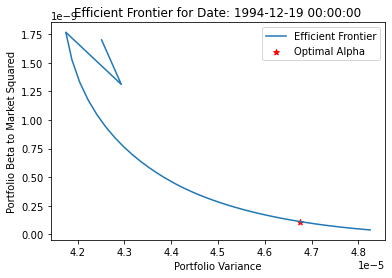

(50, 0, 15152.0101010101)


In [88]:
if __name__ == '__main__':
    
    # Artificial Testing Data 
    """
    test_strat = pd.DataFrame(np.random.randint(-1, 2, size= (25, 19)), 
                            index = pd.date_range('2023-01-01', periods = 25), 
                            columns = [f"Commodity {i}" for i in range(1, 20)])
    """
    #read in data
    data = pd.read_excel('S&P Commodity Data (with BCOM).xlsx', index_col = 0)
    data.index = pd.to_datetime(data.index)
    data = data.fillna(method = 'bfill')
    
    #extract market index
    market = data['BCOM Index']
    #data is the rest of the columns
    data = data.iloc[:, :-1]
    
    strategy = pd.read_csv('reccomended_positions_based_on_data(For Kevin and Tim).csv', index_col = 0)
    strategy.index = pd.to_datetime(strategy.index)
    
    WeightOptimizer = WeightOptimization(market, data, strategy)
    
    test_date = strategy.index[1000]
    WeightOptimizer.print_results(test_date)
    a = WeightOptimizer.plot_frontier(test_date) 
    print(a)

    #WeightOptimizer.plot_weights(test_date, numdays=252, var= True)
    
    historical_weights = pd.DataFrame(index = strategy.index, columns = strategy.columns)
    #equal_weights = pd.DataFrame(index = filtered_strategy.index, columns = filtered_strategy.columns)
    '''
    for i in range(len(strategy.index)):
        date = strategy.index[i]        
        strat_today = strategy.iloc[i]
        weights = WeightOptimizer.calculate_weights(date, alpha=10000)
        
        positions = [v for v in strat_today if v != 0]
        #eq_weights = [1/len(positions) * x for x in filtered_strategy.iloc[2]]
        
        print(weights)
        historical_weights.loc[date] = weights
        #equal_weights.loc[date] = eq_weights
    print("days equal weighted:", WeightOptimizer.equal_weighted_days)
    print("total days:", len(historical_weights.index))
    historical_weights.to_csv('historical_weights.csv')
    '''
    '''
    #port=[1]*(len(historical_weights.index)+1)
    #equal_weighted_port = [1]*(len(historical_weights.index)+1)
      
    for i in range(len(historical_weights.index)):
        date = historical_weights.index[i]
        daily_return = np.dot(historical_weights.loc[date], forward_return.loc[date])
        #equal_weighted_return = np.dot(equal_weights.loc[date], forward_return.loc[date])
        port[i+1] = port[i] * (1+daily_return)
        #equal_weighted_port[i+1] = equal_weighted_port[i] * (1+equal_weighted_return)
        
    plt.plot(port)
    plt.title('rudimentary backtest, 2016-2019 inclusive')
    plt.xlabel('days')
    plt.ylabel('return')
    '''